# TC Analysis - Niño

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import os.path as op
import xarray as xr
import requests
from io import BytesIO
import numpy as np
import pandas as pd


sys.path.append("../../../functions")
from tcs import Extract_Circle
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from ind_setup.plotting import plot_bar_probs_ONI
from data_downloaders import  download_oni_index


In [3]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

## Get Data

In [4]:
update_data = False
path_data = "../../../data"

In [5]:
if update_data:
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
    tcs = download_ibtracs(url, basin = basin)
    tcs.to_netcdf(f"{path_data}/tcs_{basin}.nc")
else:
    tcs = xr.load_dataset(f"{path_data}/tcs_{basin}.nc")

In [6]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns)

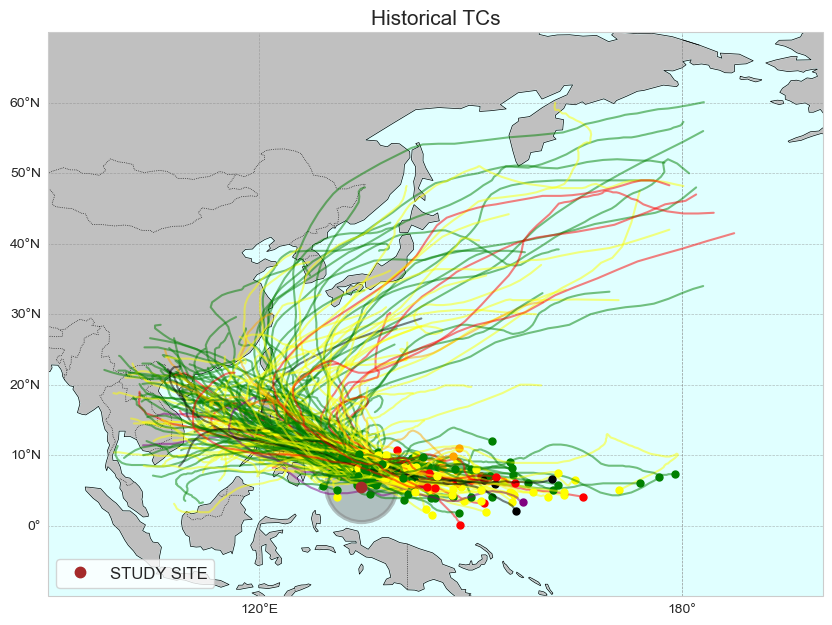

In [7]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel, tcs_sel_params.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)

## ONI index

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [8]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [9]:
if update_data:
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

oni = df1

In [10]:
import pandas as pd
tcs_g = pd.DataFrame(tcs_sel.isel(date_time = 0).time.values)
tcs_g.index = tcs_g[0]
tcs_g.index = pd.DatetimeIndex(tcs_g.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)
tcs_g['ONI'] = oni.ONI

In [11]:
tcs_sel_params['ONI'] = (('storm'), tcs_g['ONI'].values)
tcs_sel['ONI'] = (('storm'), tcs_g['ONI'].values)

In [12]:
lims = [-.5, .5]

In [13]:
oni['ONI_cat'] = np.where(oni.ONI < lims[0], -1, np.where(oni.ONI > lims[1], 1, 0))
tcs_sel_params['ONI_cat'] = (('storm'), np.where(tcs_sel.ONI < lims[0], -1, np.where(tcs_sel.ONI > lims[1], 1, 0)))

In [14]:
oni_perc_cat = oni.groupby('ONI_cat').size() / oni.shape[0] * 100
oni_perc_cat

ONI_cat
-1    27.027027
 0    46.509009
 1    26.463964
dtype: float64

In [15]:
tcs_perc_cat = tcs_sel_params.to_dataframe().groupby('ONI_cat').size() * 100 / tcs_sel_params.to_dataframe().shape[0]
tcs_perc_cat

ONI_cat
-1    30.693069
 0    50.495050
 1    18.811881
dtype: float64

In [16]:
#Relavice probability
tcs_perc_cat / oni_perc_cat

ONI_cat
-1    1.135644
 0    1.085705
 1    0.710849
dtype: float64

In [17]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)

Text(0, 0.5, 'TC counts')

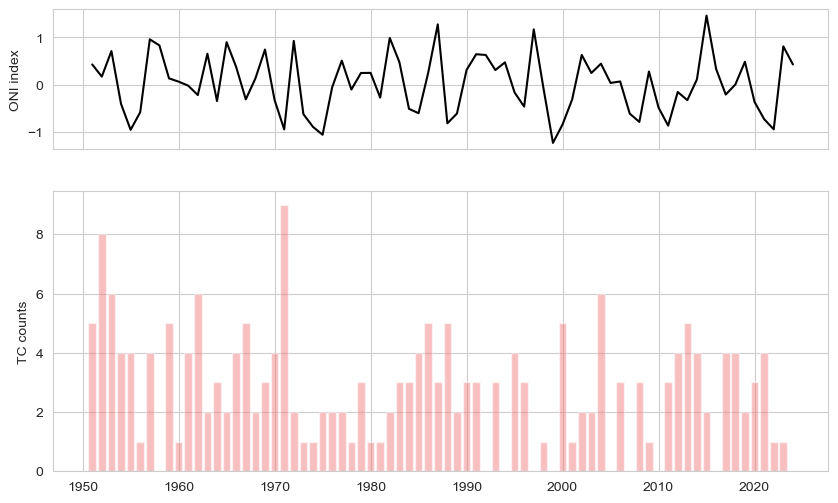

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize = (10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
oni.groupby(oni.index.year).mean().ONI.plot(ax = axs[0], color = 'black', label = 'ONI')
axs[0].set_ylabel('ONI index')
axs[1].bar(x = u, height = cu, color='lightcoral', edgecolor='white', alpha = .5, label = 'TC counts')
axs[1].set_ylabel('TC counts')


In [19]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
tc_c = pd.DataFrame(cu, index = u)

In [20]:
time_sev = tcs_sel_params.where(tcs_sel_params.category >= 3, drop = True).dmin_date.dt.year.values
u_sev, cu_sev = np.unique(time_sev, return_counts=True)
tc_c_sev = pd.DataFrame(cu_sev, index = u_sev)

In [21]:
oni_y = oni.groupby(oni.index.year).mean()
oni_y['tc_counts'] = tc_c
oni_y['tc_counts_sev'] = tc_c_sev

In [22]:
oni_y['oni_cat'] = oni_y.ONI_cat.values

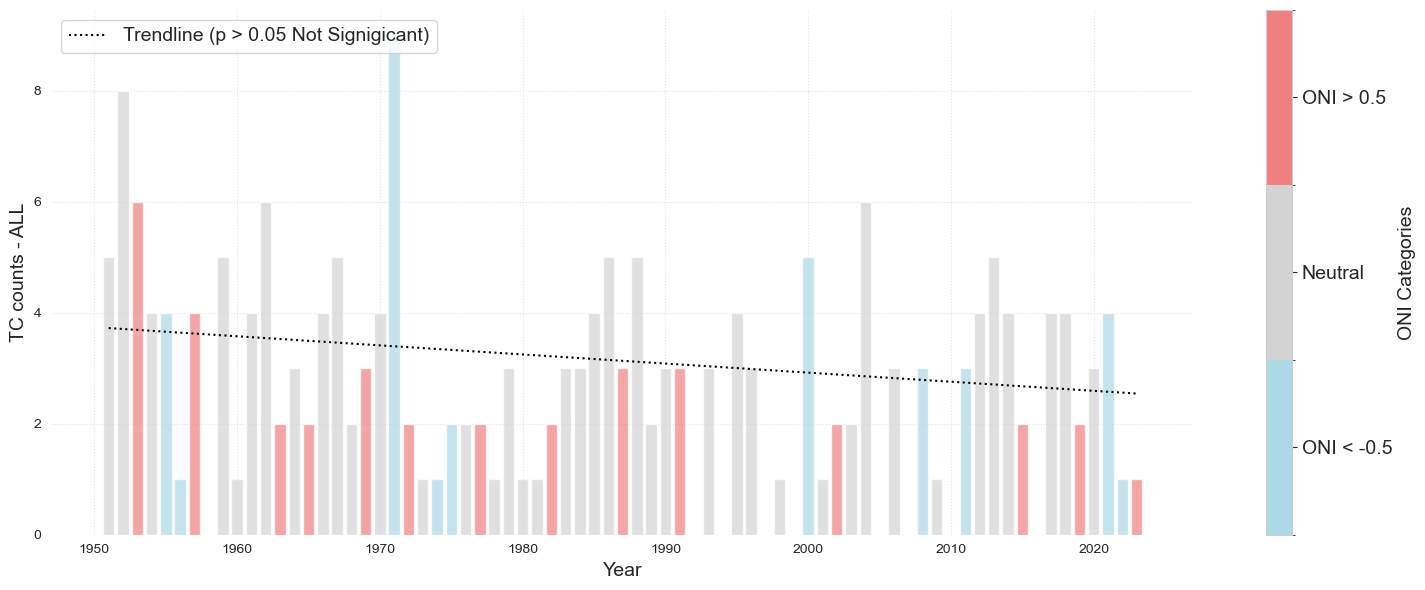

In [23]:
ax = plot_bar_probs_ONI(oni_y, 'tc_counts', y_label= 'TC counts - ALL');


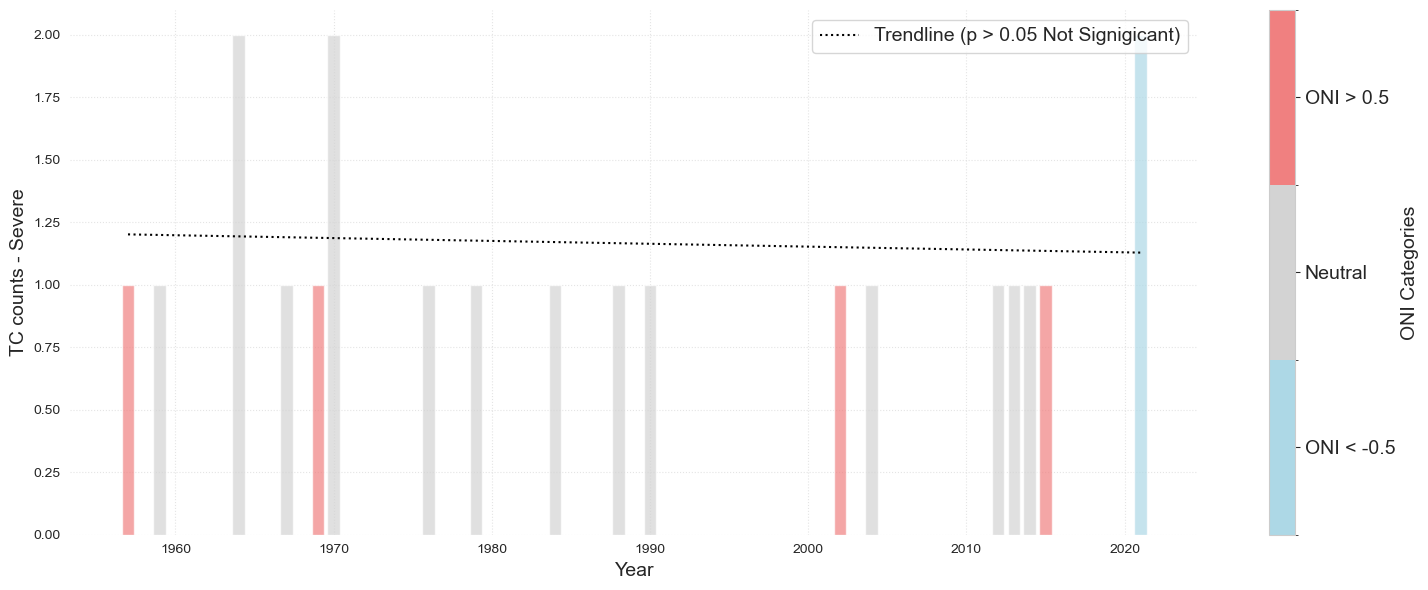

In [24]:
ax = plot_bar_probs_ONI(oni_y, 'tc_counts_sev', y_label= 'TC counts - Severe');


## ALL TCs

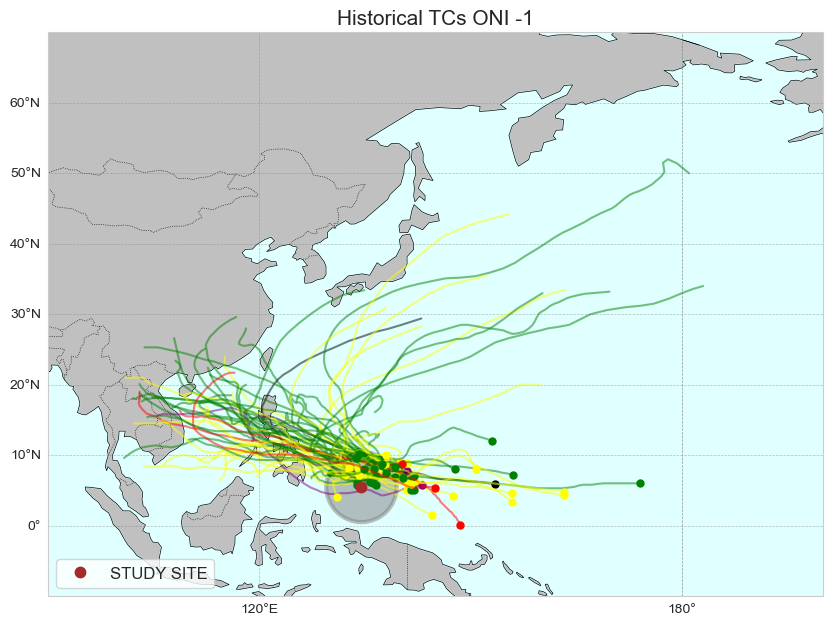

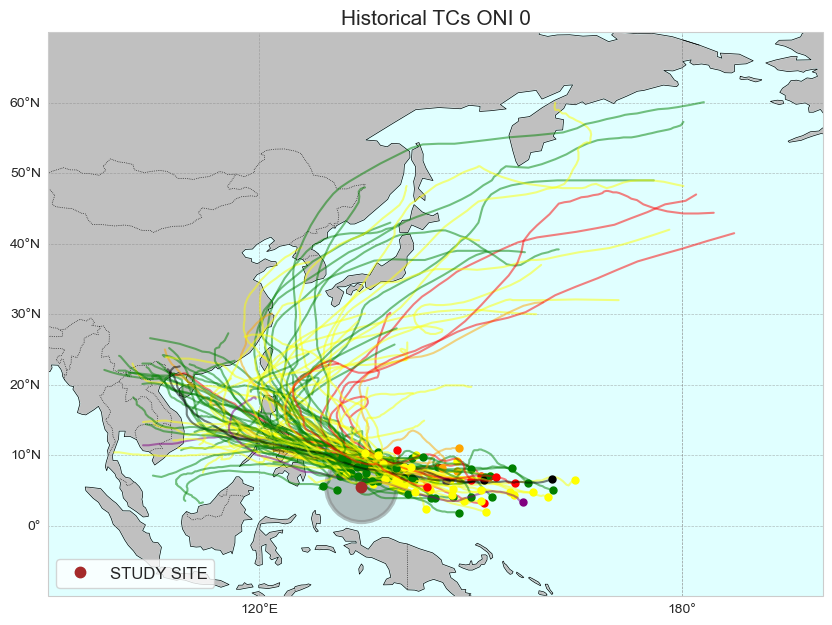

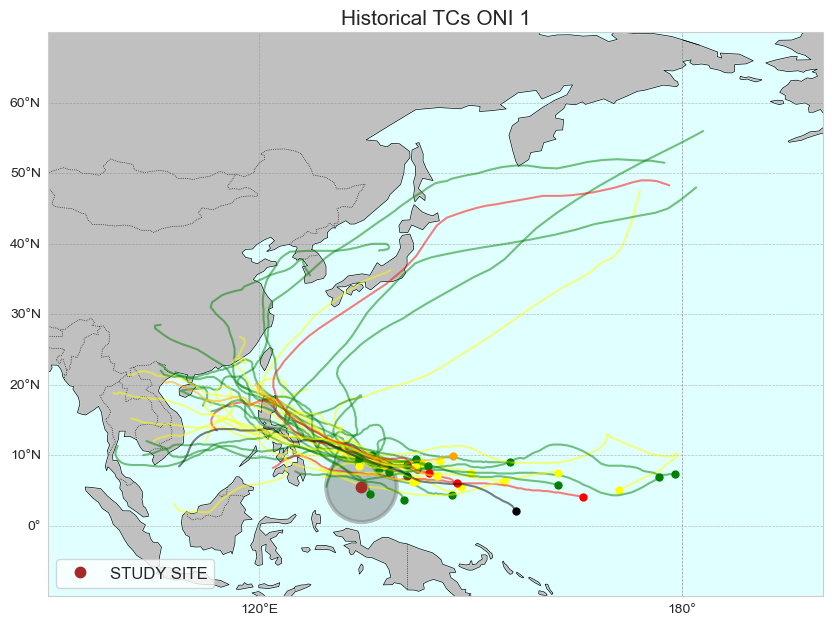

In [25]:
for category in [-1, 0, 1]:

    tcs_cat = tcs_sel.where(tcs_sel_params.ONI_cat == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.ONI_cat == category, drop = True)

    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs ONI {category}', fontsize=15)

## SEVERE TCs

Category 3, 4 and 5

In [26]:
storms_severe_ids = tcs_sel_params.storm.where(tcs_sel_params.category >= 3, drop = True).values

In [27]:
storms_severe = tcs_sel.sel(storm = storms_severe_ids)
storm_severe_params = tcs_sel_params.sel(storm = storms_severe_ids)

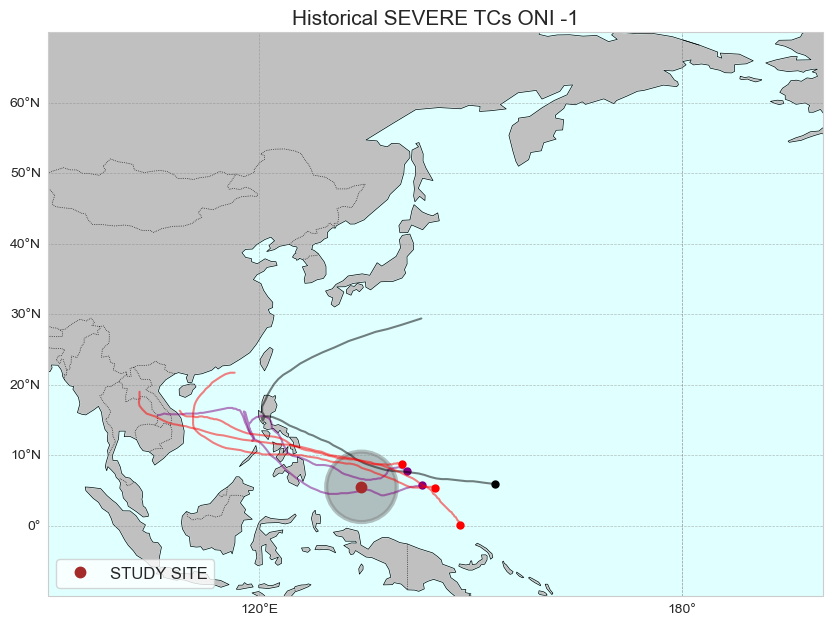

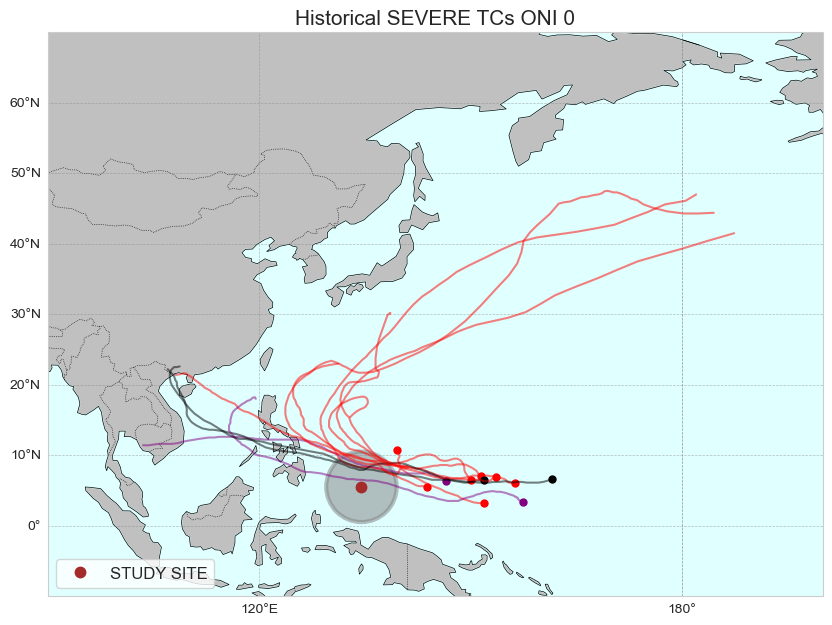

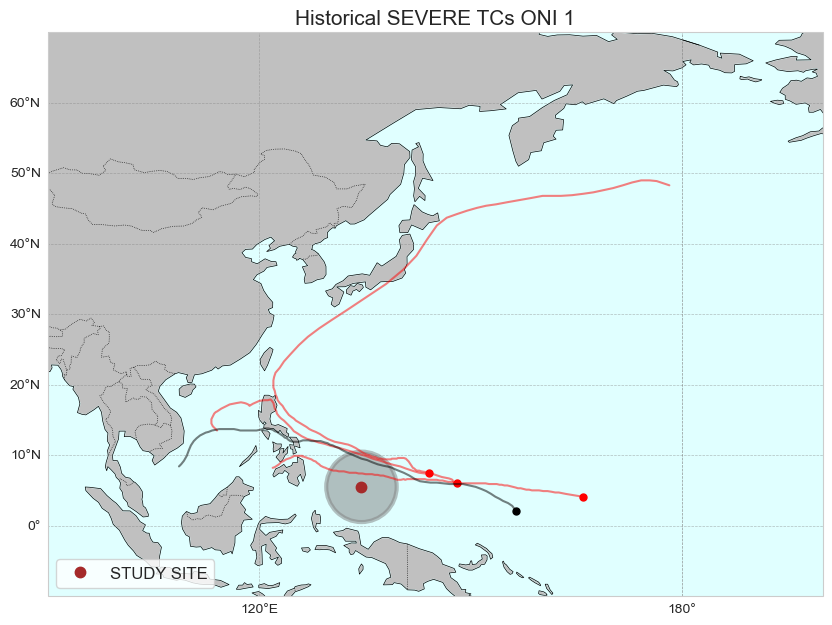

In [28]:
for category in [-1, 0, 1]:

    tcs_cat = storms_severe.where(storm_severe_params.ONI_cat == category, drop = True)
    tcs_cat_params = storm_severe_params.where(storm_severe_params.ONI_cat == category, drop = True)

    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical SEVERE TCs ONI {category}', fontsize=15)